In [1]:
from wobble.interp import interp
import h5py
import wobble
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starid = 'hip54287'
filename = '../data/'+starid+'_e2ds.hdf5'

In [3]:
with h5py.File(filename) as f:
    data = np.log(f['data'][30])
    data_xs = np.log(f['xs'][30])
    ivars = np.copy(f['ivars'][30])
    pipeline_rvs = -1. * np.copy(f['pipeline_rvs'])

In [4]:
for n in range(len(data)):
    data[n] -= wobble.fit_continuum(data_xs[n], data[n], ivars[n])

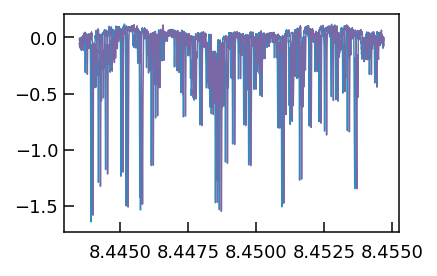

In [5]:
plt.plot(data_xs[0], data[0])
plt.plot(data_xs[5], data[5])

In [6]:
len(data)

40

In [7]:
a = wobble.star(starid+'_e2ds.hdf5', orders=[30])
a.initialize_model(0, 'star')
model_xs, model_ys = a.model_xs_star[0], a.model_ys_star[0]

initializing star model...


In [8]:
np.shape(model_xs)

(6815,)

In [9]:
import tensorflow as tf

In [10]:
T = tf.float64
model_xs_tensor = tf.constant(model_xs, dtype=T)
model_ys_tensor = tf.Variable(model_ys, dtype=T)
data_tensor = tf.constant(data, dtype=T)
xs_tensor = tf.constant(data_xs, dtype=T)
ivars_tensor = tf.constant(ivars, dtype=T)

In [11]:
rvs_tensor = tf.Variable(pipeline_rvs, dtype=T)

In [12]:
c = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return tf.sqrt(frac)

In [13]:
nll = tf.constant(0.0, dtype=T)
for n in range(len(data)):
    shifted_xs = xs_tensor[n] + tf.log(doppler(rvs_tensor[n]))
    model = interp(shifted_xs, model_xs_tensor, model_ys_tensor)
    nll += 0.5*tf.reduce_sum((data_tensor - model)**2 * ivars_tensor[n])
    
grad_model = tf.gradients(nll, [model_ys_tensor])
grad_rvs = tf.gradients(nll, [rvs_tensor])

In [19]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print "one"
    g_model = session.run(grad_model)
    print "two"
    g_rvs = session.run(grad_rvs)
    print "three"
    g_model = session.run(grad_model)
    print "four"
    g_rvs = session.run(grad_rvs)
    print "five"

one
two
three
four
five


In [38]:
g_model_tensor = tf.gather(g_model[0].values, g_model[0].indices)

In [41]:
print g_model_tensor

Tensor("Gather_121:0", shape=(1254240,), dtype=float64)
